<a href="https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/A_tale_of_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to experiment with different quanitization strategies supported by the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization) and TensorFlow Lite. These will include:
- Post-training quantization
- Quantization-aware training

We will start by training an image classification model using the traditional transfer learning process with a pre-trained MobileNetV2 network. We will then proceed towards the different quantization schemes. 

## Initial setup

In [0]:
# Why `tf-nightly`?: https://github.com/tensorflow/model-optimization/issues/368
!pip uninstall -q -y tensorflow tensorflow-gpu
!pip install -q tf-nightly

In [0]:
# Install optimization toolkit and wandb
!pip install -q tensorflow-model-optimization
!pip install -q wandb

In [0]:
# wandb authorization
import wandb
wandb.login()

In [4]:
# TensorFlow import
import tensorflow as tf
print(tf.__version__)

2.2.0-dev20200506


In [5]:
# Which GPU?
!nvidia-smi

Thu May  7 02:35:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Other imports
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
# Fix the random seeds
np.random.seed(666)
tf.random.set_seed(666)

## Dataset preparation

In [8]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


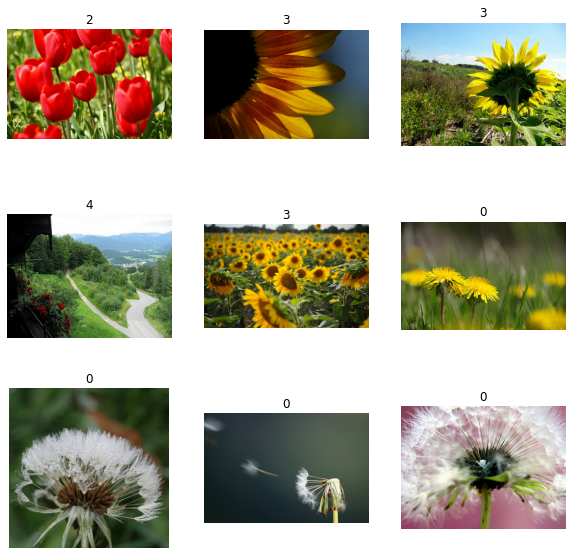

In [9]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

In [0]:
# Image resize
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [0]:
# Normalization utils
def normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

In [0]:
# Construct the batched dataset
batch_size = 32
AUTO = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(normalize_img, num_parallel_calls=AUTO).\
    shuffle(1024).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=AUTO).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Initial model training setup

In [13]:
# Load the MobileNetV2 model but exclude the classification layers
EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
def get_training_model(trainable=False):
    # We will set it to both True and False
    EXTRACTOR.trainable = trainable
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

In [0]:
# Train the model with no fine-tuning
wandb.init(project="tale-of-quantization", id="normal-training-no-ft")
flower_model = get_training_model(trainable=False)
start = time.time()
history = flower_model.fit(train_ds,
              validation_data=validation_ds,
              epochs=10,
              callbacks=[WandbCallback()])
end = time.time()-start
wandb.log({"training_time": end})
print("Total training time: ",end)

Epoch 1/10
98/98 [==============================] - 18s 184ms/step - loss: 0.7111 - accuracy: 0.7423 - val_loss: 0.8786 - val_accuracy: 0.6709
Epoch 2/10
98/98 [==============================] - 14s 148ms/step - loss: 0.4048 - accuracy: 0.8513 - val_loss: 0.8136 - val_accuracy: 0.7164
Epoch 3/10
98/98 [==============================] - 14s 144ms/step - loss: 0.3788 - accuracy: 0.8651 - val_loss: 0.8159 - val_accuracy: 0.7218
Epoch 4/10
98/98 [==============================] - 14s 142ms/step - loss: 0.3129 - accuracy: 0.8878 - val_loss: 0.8625 - val_accuracy: 0.7182
Epoch 5/10
98/98 [==============================] - 14s 145ms/step - loss: 0.2666 - accuracy: 0.9093 - val_loss: 0.7028 - val_accuracy: 0.7564
Epoch 6/10
98/98 [==============================] - 14s 143ms/step - loss: 0.2290 - accuracy: 0.9154 - val_loss: 0.5954 - val_accuracy: 0.7782
Epoch 7/10
98/98 [==============================] - 14s 141ms/step - loss: 0.2349 - accuracy: 0.9199 - val_loss: 0.8021 - val_accuracy: 0.7436

We see that the model overfits largely, let's try to mitigate this with the virtue of fine-tuning. While fine-tuning, it's important to start with a relatively lower learning rate so that the pre-trained weights do not get broken too fast. 

In [0]:
# Train model with fine-tuning
wandb.init(project="tale-of-quantization", id="normal-training-fine")
flower_model = get_training_model(trainable=True)
flower_model.compile(loss="sparse_categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(1e-5),
                          metrics=["accuracy"])
start = time.time()
history = flower_model.fit(train_ds,
              validation_data=validation_ds,
              epochs=10,
              callbacks=[WandbCallback()])
end = time.time()-start
wandb.log({"training_time": end})
print("Total training time: ",end)

Epoch 1/10
98/98 [==============================] - 47s 482ms/step - loss: 1.6801 - accuracy: 0.3282 - val_loss: 1.2701 - val_accuracy: 0.4618
Epoch 2/10
98/98 [==============================] - 38s 390ms/step - loss: 1.0573 - accuracy: 0.5897 - val_loss: 0.9176 - val_accuracy: 0.6600
Epoch 3/10
98/98 [==============================] - 38s 386ms/step - loss: 0.7625 - accuracy: 0.7237 - val_loss: 0.7063 - val_accuracy: 0.7436
Epoch 4/10
98/98 [==============================] - 38s 388ms/step - loss: 0.5930 - accuracy: 0.7955 - val_loss: 0.5781 - val_accuracy: 0.7818
Epoch 5/10
98/98 [==============================] - 38s 390ms/step - loss: 0.4957 - accuracy: 0.8240 - val_loss: 0.4847 - val_accuracy: 0.8109
Epoch 6/10
98/98 [==============================] - 38s 390ms/step - loss: 0.4140 - accuracy: 0.8603 - val_loss: 0.4241 - val_accuracy: 0.8400
Epoch 7/10
98/98 [==============================] - 39s 394ms/step - loss: 0.3613 - accuracy: 0.8776 - val_loss: 0.3897 - val_accuracy: 0.8455

We see more stabilized training behavior in this case. Let's now see how much this model weighs. We can see it in [here](https://app.wandb.ai/sayakpaul/tale-of-quantization/runs/normal-training-fine/files?workspace=user-sayakpaul): 

![](https://i.ibb.co/PjNMMt6/Screen-Shot-2020-04-29-at-7-00-18-PM.png)

Now, let's see how we can make use of quantization-aware training and evaluate its effect as well. 

## Quantization-aware training

In [0]:
# Import `tfmot` library
import tensorflow_model_optimization as tfmot

In [0]:
# Allow the model to be trained in a quantization-aware manner
flower_model = get_training_model(trainable=True)
q_flower_model = tfmot.quantization.keras.quantize_model(flower_model)
q_flower_model.summary()

In [17]:
# Train the model
wandb.init(project="tale-of-quantization", id="qaware-training-ft-crctd")
q_flower_model.compile(loss="sparse_categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(1e-5),
                          metrics=["accuracy"])
start = time.time()
history = q_flower_model.fit(train_ds,
              validation_data=validation_ds,
              epochs=10,
              callbacks=[WandbCallback()])
end = time.time() - start
wandb.log({"training_time": end})
print("Total training time: ",end)

Epoch 1/10
98/98 [==============================] - 68s 697ms/step - loss: 0.9581 - accuracy: 0.6327 - val_loss: 0.6678 - val_accuracy: 0.7564
Epoch 2/10
98/98 [==============================] - 66s 674ms/step - loss: 0.5238 - accuracy: 0.8125 - val_loss: 0.4584 - val_accuracy: 0.8418
Epoch 3/10
98/98 [==============================] - 65s 664ms/step - loss: 0.3667 - accuracy: 0.8721 - val_loss: 0.4355 - val_accuracy: 0.8418
Epoch 4/10
98/98 [==============================] - 66s 668ms/step - loss: 0.2847 - accuracy: 0.8981 - val_loss: 0.3414 - val_accuracy: 0.8891
Epoch 5/10
98/98 [==============================] - 65s 667ms/step - loss: 0.2188 - accuracy: 0.9253 - val_loss: 0.2971 - val_accuracy: 0.9018
Epoch 6/10
98/98 [==============================] - 66s 670ms/step - loss: 0.1690 - accuracy: 0.9497 - val_loss: 0.2712 - val_accuracy: 0.9091
Epoch 7/10
98/98 [==============================] - 66s 669ms/step - loss: 0.1259 - accuracy: 0.9641 - val_loss: 0.2472 - val_accuracy: 0.9164

Although this model takes more time to train it also performs the best (although starts to overfit). Increase in the training time is obvious because now the process is figuring what how to compensate for the loss that would get induced because of quantization. 

In [18]:
# Serializing the model and seeing the size of it
q_flower_model.save("q_flower_model.h5")
!ls -lh q_flower_model.h5

-rw-r--r-- 1 root root 35M May  7 02:50 q_flower_model.h5


### A note on de-serializing this model & using it later

In [0]:
# `quantize_scope` is needed for deserializing HDF5 models.
with tfmot.quantization.keras.quantize_scope():
    loaded_model = tf.keras.models.load_model("q_flower_model.h5")

Note that `q_flower_model` is _not quantized_ yet, it's weights are still in float32. To quantize it we would need to make sure of the APIs provided by TensorFlow Lite. 

## Post-training quantization and model evaluation

In [0]:
# Quantize `q_flower_model` (this one was trained with QAT)
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
f = open("flower_model.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

In [20]:
# Size of this model
ls -lh flower_model.tflite

-rw-r--r-- 1 root root 3.3M May  7 02:50 flower_model.tflite


We see the reduction in model's size. For making this more comparable, we will now do two things:
- Quantize the normal `flower_model` using the same quantization configuration and see the size of the converted model. 
- Evaluate both of these models.

In [0]:
# Load the non-QAT model
non_qat_flower_model = get_training_model()
model = wandb.restore("model-best.h5", root="/content/wandb/run-20200429_131751-normal-training-fine")
non_qat_flower_model.load_weights(model.name)

In [0]:
# Quantize `flower_model`
converter = tf.lite.TFLiteConverter.from_keras_model(non_qat_flower_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
f = open("normal_flower_model.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

In [0]:
# Size of this model
ls -lh normal_flower_model.tflite

-rw-r--r-- 1 root root 2.9M Apr 29 14:11 normal_flower_model.tflite


Of course, both the TF Lite model sizes are the same as both the starter models were in float32. Evaluating them further for performance will give us a better picture. It's important to note that the way we quantized two models above is referred to as _post training quantization_ and you can know more about it from [here](https://www.tensorflow.org/lite/performance/post_training_quantization). 

We will be making use of a utility function to evaluate both the TF Lite models. 

In [0]:
# A helper function to evaluate the TF Lite model using "validation" dataset.
# Referred from: https://www.tensorflow.org/lite/performance/post_training_integer_quant
def evaluate_model(interpreter):
    accurate_count = 0

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    predictions = []
    for (val_images, val_labels) in validation_ds:
        for val_image, val_label in zip(val_images, val_labels):
            val_image = tf.expand_dims(val_image, 0)
            interpreter.set_tensor(input_index, val_image)

            # Run inference.
            interpreter.invoke()

            # Post-processing: remove batch dimension and find the digit with highest
            # probability.
            probability = interpreter.get_tensor(output_index)
            flower_id = np.argmax(probability[0])
            predictions.append(flower_id)

            # Compare prediction results with ground truth labels to calculate accuracy.
            if flower_id == val_label:
                accurate_count += 1
    
    accuracy = accurate_count * 1.0 / len(predictions)

    return accuracy

Let's go with `flower_model.tflite` first i.e. the one converted from a model that was trained in a quantization-aware manner. 

In [22]:
# Set up wandb to log all the important information
wandb.init(project="tale-of-quantization", id="post-training-qat-crctd")

W&B Run: https://app.wandb.ai/sayakpaul/tale-of-quantization/runs/post-training-qat-crctd

In [23]:
# Load the model into interpreters
interpreter_qat = tf.lite.Interpreter(model_path="flower_model.tflite")
interpreter_qat.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_qat))

0.9272727272727272


In [0]:
# Log
table = wandb.Table(columns=["Model type", "Optimization policy", "Size", "Accuracy (%)"])
table.add_data("Quantized model (QAT)", "`tf.lite.Optimize.DEFAULT`", "3.3 MB", "92.72")
wandb.log({"model_stats": table})

Time to evaluate the `normal_flower_model.tflite` model.

In [0]:
# Set up wandb to log all the important information
wandb.init(project="tale-of-quantization", id="post-training-no-qat")

W&B Run: https://app.wandb.ai/sayakpaul/tale-of-quantization/runs/post-training-no-qat

In [0]:
# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="normal_flower_model.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.7327272727272728


In [0]:
table = wandb.Table(columns=["Model type", "Optimization policy", "Size", "Accuracy (%)"])
table.add_data("Quantized model (No QAT)", "`tf.lite.Optimize.DEFAULT`", "2.9 MB", "73.27")
wandb.log({"model_stats": table})

We see that the quantization-aware training (QAT) model's quantized version performs much better. Let's see if we can improve the accuracy score a bit further. 

In [0]:
# Set up wandb to log all the important information
wandb.init(project="tale-of-quantization", id="post-training-qat-float")

W&B Run: https://app.wandb.ai/sayakpaul/tale-of-quantization/runs/post-training-qat-float

In [0]:
# Quantize `q_flower_model` with no policy (float)
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
quantized_tflite_model = converter.convert()
f = open("flower_model_no_pol.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh flower_model_no_pol.tflite

-rw-r--r-- 1 root root 11M Apr 29 14:27 flower_model_no_pol.tflite


There's an increase in model size, though. Let's evaluate this model. 

In [0]:
# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="flower_model_no_pol.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.9109090909090909


In [0]:
table = wandb.Table(columns=["Model type", "Optimization policy", "Size", "Accuracy (%)"])
table.add_data("Quantized model (QAT)", "`None`", "11 MB", "91.09")
wandb.log({"model_stats": table})

Okay, we can retain the accuracy score in this case. Let's do the same for the model **not** trained using QAT. 

In [0]:
# Set up wandb to log all the important information
wandb.init(project="tale-of-quantization", id="post-training-no-qat-float")

W&B Run: https://app.wandb.ai/sayakpaul/tale-of-quantization/runs/post-training-no-qat-float

In [0]:
# Quantize `flower_model` (no QAT)
converter = tf.lite.TFLiteConverter.from_keras_model(non_qat_flower_model)
quantized_tflite_model = converter.convert()
f = open("normal_flower_model_no_pol.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh normal_flower_model_no_pol.tflite

-rw-r--r-- 1 root root 11M Apr 29 14:30 normal_flower_model_no_pol.tflite


In [0]:
# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="normal_flower_model_no_pol.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.88


In [0]:
table = wandb.Table(columns=["Model type", "Optimization policy", "Size", "Accuracy (%)"])
table.add_data("Quantized model (No QAT)", "`None`", "11 MB", "88")
wandb.log({"model_stats": table})

There's a 2% accuracy drop in this case. With TensorFlow Lite, we can specify specific optimization policies during the conversion process. There are three options [available](https://www.tensorflow.org/api_docs/python/tf/lite/Optimize):
- DEFAULT
- OPTIMIZE_FOR_LATENCY
- OPTIMIZE_FOR_SIZE

Let's try this one - `OPTIMIZE_FOR_LATENCY`.

In [0]:
# Quantize `q_flower_model` for latency
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
quantized_tflite_model = converter.convert()
f = open("flower_model_latency.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh flower_model_latency.tflite

-rw-r--r-- 1 root root 2.9M Apr 28 08:30 flower_model_latency.tflite


In [0]:
# Evaluation

# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="flower_model_latency.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.7854545454545454


Performance again drops. Let's try the other variant. 

In [0]:
# Quantize `q_flower_model` for size
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
quantized_tflite_model = converter.convert()
f = open("flower_model_size.tflite", "wb")
f.write(quantized_tflite_model)
f.close()

!ls -lh flower_model_size.tflite

-rw-r--r-- 1 root root 2.9M Apr 28 08:33 flower_model_size.tflite


In [0]:
# Evaluation

# Load the model into interpreters
interpreter_nor = tf.lite.Interpreter(model_path="flower_model_size.tflite")
interpreter_nor.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_nor))

0.7854545454545454


Note that the performance and size can further be tuned by using a representative dataset to calibrate the dynamic range of the activations. You can know more about it from here: https://www.tensorflow.org/lite/performance/post_training_integer_quant. Also note that this technique does not yet support the FakeQuantization layers introduced during the QAT. 